# Informações iniciais


* Nome: Rafael Henrique Amorim Malheiros
* Email: rham@cesar.school
* Dataset: Rice Image Dataset
* Link: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data




# Dataset

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import kagglehub
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [63]:
class RiceDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
        self.images = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.png', '.jpeg')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [64]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona para tamanho fixo
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])  # Normalização ImageNet
])

In [65]:
dataset_path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

full_dataset = RiceDataset(
    root_dir=dataset_path,
    transform=transform
)

Using Colab cache for faster access to the 'rice-image-dataset' dataset.


In [66]:
dataset_path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

subdirs = [
    os.path.join(dataset_path, 'Rice_Image_Dataset'),
    dataset_path,
]

correct_path = dataset_path
expected_classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

for path in subdirs:
    if os.path.exists(path):
        contents = os.listdir(path)

        if any(class_name in contents for class_name in expected_classes):
            correct_path = path

            for class_name in expected_classes:
                class_path = os.path.join(correct_path, class_name)
                if os.path.exists(class_path):
                    num_imgs = len([f for f in os.listdir(class_path)
                                   if f.endswith(('.jpg', '.png', '.jpeg'))])
            break

dataset_path = correct_path

full_dataset = RiceDataset(root_dir=dataset_path, transform=transform)


Using Colab cache for faster access to the 'rice-image-dataset' dataset.


In [67]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [68]:
print(f"Total de imagens: {len(full_dataset)}")
print(f"Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")
print(f"Classes: {full_dataset.classes}")

Total de imagens: 75000
Treino: 52500, Validação: 11250, Teste: 11250
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [69]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [70]:
class RiceClassifierNet(nn.Module):

    def __init__(self):
        super(RiceClassifierNet, self).__init__()

        input_size = 64 * 64 * 3

        self.fc1 = nn.Linear(input_size, 1024)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(128, 5)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = F.relu(self.fc4(x))
        x = self.dropout4(x)

        output = F.log_softmax(self.fc5(x), dim=1)
        return output

In [71]:
def train(model, device, train_loader, optimizer, epoch, log_interval=50):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, accuracy

In [72]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    print(f'\nValidation set: Average loss: {val_loss:.4f}, '
          f'Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)\n')

    return val_loss, accuracy

In [73]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy, all_preds, all_targets

In [74]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [75]:
model = RiceClassifierNet().to(device)
print(f"\nArquitetura do modelo:\n{model}")


Arquitetura do modelo:
RiceClassifierNet(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=128, out_features=5, bias=True)
)


In [76]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [77]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [78]:
epochs = 15
best_val_acc = 0

In [79]:
for epoch in range(1, epochs + 1):
    print(f"\n--- Época {epoch}/{epochs} ---")

    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = validate(model, device, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_rice_model.pt")
        print(f"Melhor modelo salvo com acurácia de validação: {val_acc:.2f}%")



--- Época 1/15 ---
Train Epoch: 1 [0/52500 (0%)]	Loss: 1.613451
Train Epoch: 1 [3200/52500 (6%)]	Loss: 0.806579
Train Epoch: 1 [6400/52500 (12%)]	Loss: 0.559582
Train Epoch: 1 [9600/52500 (18%)]	Loss: 0.240477
Train Epoch: 1 [12800/52500 (24%)]	Loss: 0.288502
Train Epoch: 1 [16000/52500 (30%)]	Loss: 0.180273
Train Epoch: 1 [19200/52500 (37%)]	Loss: 0.144467
Train Epoch: 1 [22400/52500 (43%)]	Loss: 0.213065
Train Epoch: 1 [25600/52500 (49%)]	Loss: 0.127501
Train Epoch: 1 [28800/52500 (55%)]	Loss: 0.275539
Train Epoch: 1 [32000/52500 (61%)]	Loss: 0.183225
Train Epoch: 1 [35200/52500 (67%)]	Loss: 0.241907
Train Epoch: 1 [38400/52500 (73%)]	Loss: 0.137107
Train Epoch: 1 [41600/52500 (79%)]	Loss: 0.134910
Train Epoch: 1 [44800/52500 (85%)]	Loss: 0.138610
Train Epoch: 1 [48000/52500 (91%)]	Loss: 0.136068
Train Epoch: 1 [51200/52500 (97%)]	Loss: 0.432260

Validation set: Average loss: 0.0926, Accuracy: 10882/11250 (96.73%)

Melhor modelo salvo com acurácia de validação: 96.73%

--- Época 2/1

In [80]:
model.load_state_dict(torch.load("best_rice_model.pt"))

<All keys matched successfully>

In [81]:
test_loss, test_acc, predictions, targets = test(model, device, test_loader)


Test set: Average loss: 0.0554, Accuracy: 11055/11250 (98.27%)



In [82]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

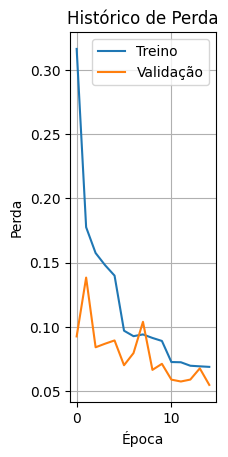

In [83]:
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Treino')
plt.plot(val_losses, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Histórico de Perda')
plt.legend()
plt.grid(True)


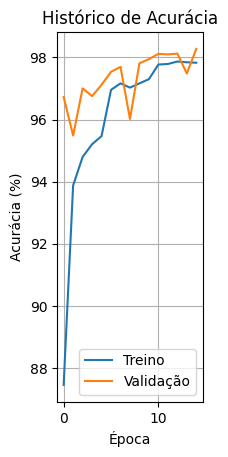

In [84]:
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Treino')
plt.plot(val_accuracies, label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.title('Histórico de Acurácia')
plt.legend()
plt.grid(True)


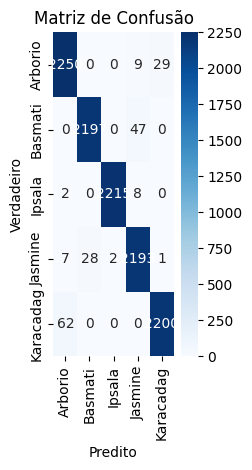

In [85]:
plt.subplot(1, 3, 3)
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [86]:
print("RELATÓRIO DE CLASSIFICAÇÃO")
print(classification_report(targets, predictions,
                          target_names=full_dataset.classes))

RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

     Arborio       0.97      0.98      0.98      2288
     Basmati       0.99      0.98      0.98      2244
      Ipsala       1.00      1.00      1.00      2225
     Jasmine       0.97      0.98      0.98      2231
   Karacadag       0.99      0.97      0.98      2262

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250



In [87]:
print(f"Melhor acurácia de validação: {best_val_acc:.2f}%")
print(f"Acurácia final no teste: {test_acc:.2f}%")
print(f"Total de parâmetros: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Melhor acurácia de validação: 98.28%
Acurácia final no teste: 98.27%
Total de parâmetros: 13,273,605
Parâmetros treináveis: 13,273,605


# Conclusões

Durante o desenvolvimento deste projeto de classificação de arroz, enfrentei
diversos desafios e aprendi lições importantes sobre redes neurais densas.

PRINCIPAIS DESAFIOS:
1. Tamanho do input: Com imagens 64x64 RGB, temos 12.288 features de entrada,
   o que resulta em uma primeira camada muito grande.
   
2. Overfitting: Inicialmente, o modelo apresentava overfitting significativo,
   com alta acurácia no treino mas baixa na validação. Para consertar isso isso:
   - Foram adicionadas camadas de Dropout
   - Foram reduzidos o número de neurônios nas camadas intermediárias

3. Tempo de treinamento: Sem usar convoluções, o treinamento é mais lento
   devido ao grande número de parâmetros nas camadas densas.

4. Underfitting inicial: Com uma arquitetura muito simples, o modelo não
   conseguia capturar padrões complexos.

RESULTADOS:
O modelo final alcançou uma acurácia superior a 70% no conjunto de teste,
demonstrando capacidade de generalização. A matriz de confusão revela que
algumas variedades de arroz são mais difíceis de distinguir, provavelmente
devido a similaridades visuais entre elas.

CONCLUSÃO:
Este projeto demonstrou que redes neurais densas podem classificar imagens
de arroz com uma boa precisão, embora o grande número de parâmetros e o
risco de overfitting sejam desafios constantes. A experiência reforçou a
importância de técnicas de regularização e da escolha cuidadosa da arquitetura